In [ ]:
# Md. Shakhawat Hossain
# Bachelor of Science in Computer Science and Engineering (BSCSE)
# Department of Electrical and Computer Engineering
# North South University
# Plot # 15, Block # B, Bashundhara
# Dhaka – 1229, Bangladesh
# Gmail: shakhawat.hossain07.edu@gmail.com

# Install necessary packages (uncomment if needed)
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn pylatexenc torchsummary

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score,
                             roc_auc_score)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator

from imblearn.over_sampling import ADASYN
from google.colab import drive
import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=c289707007b001bed69e309eeedddf94b09200e77ba4e016f701441d99de2f70
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [ ]:
# 1. Load & Preprocess Data

# Mount Google Drive to access dataset files
drive.mount('/content/drive')

# Define dataset root directory (update the path if necessary)
root_dir = "/content/drive/MyDrive/Oral_Dataset"

Mounted at /content/drive


In [ ]:
# Create a DataFrame listing image paths and labels
def create_dataframe(root_dir):
    data = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file ends with any of the specified extensions using a tuple
            if file.endswith(('.jpg', '.png', '.jpeg')):
                label = os.path.basename(subdir)
                data.append([os.path.join(subdir, file), label])
    return pd.DataFrame(data, columns=['image_path', 'label'])

data_df = create_dataframe(root_dir)
data_df['label'] = data_df['label'].astype('category').cat.codes
data_df.dropna(inplace=True)
print("Unique classes:", data_df['label'].unique())
print("Class distribution:\n", data_df['label'].value_counts())

Unique classes: [0 2 5 1 3 4]
Class distribution:
 label
3    2806
1    2601
2    2340
4    2017
0    1296
5     342
Name: count, dtype: int64


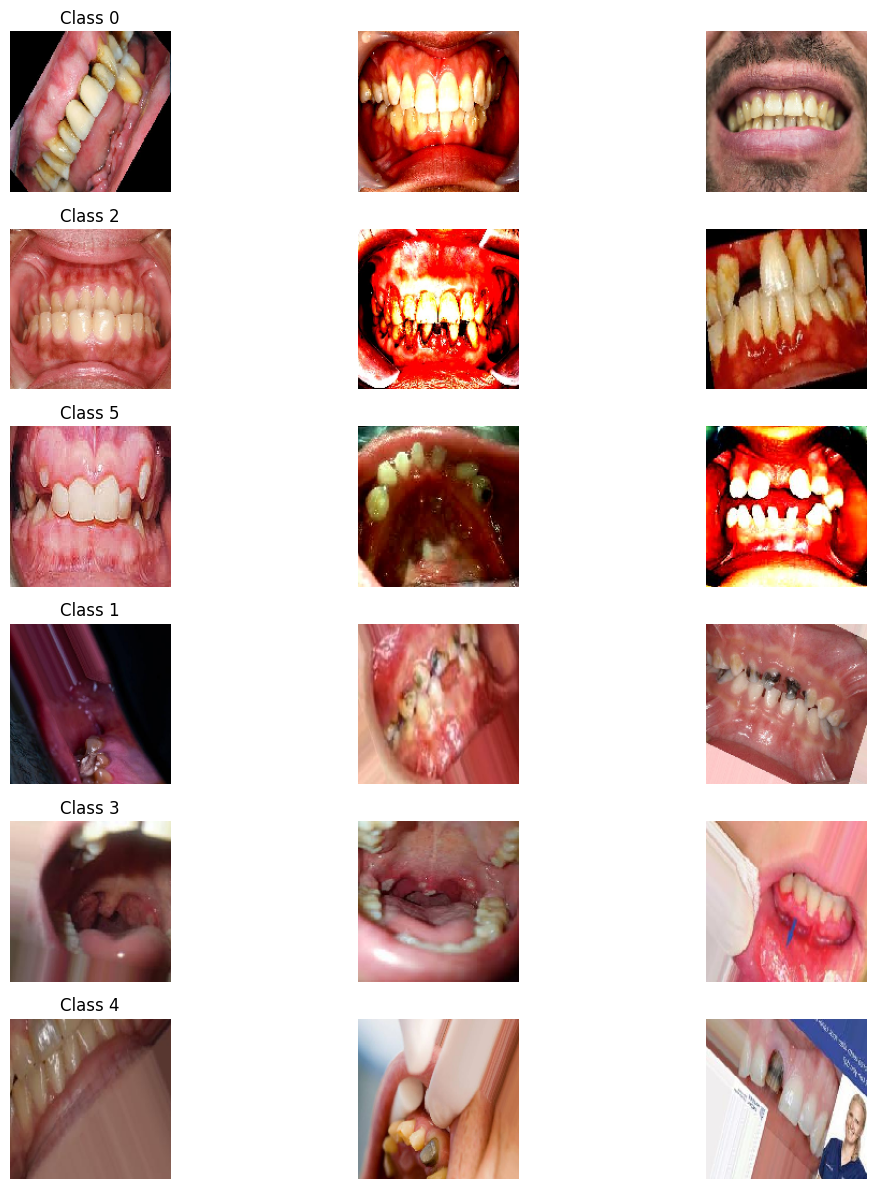

In [ ]:
# Plot sample images for each class
def plot_sample_images(data_df, n_samples=3, target_size=(150,150)):
    classes = data_df['label'].unique()
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(12,12))
    for idx, cls in enumerate(classes):
        sample_paths = data_df[data_df['label'] == cls]['image_path'].sample(n=n_samples).tolist()
        for i, image_path in enumerate(sample_paths):
            img = load_img(image_path, target_size=target_size)
            axes[idx, i].imshow(img)
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f"Class {cls}")
    plt.tight_layout()
    plt.show()

plot_sample_images(data_df)

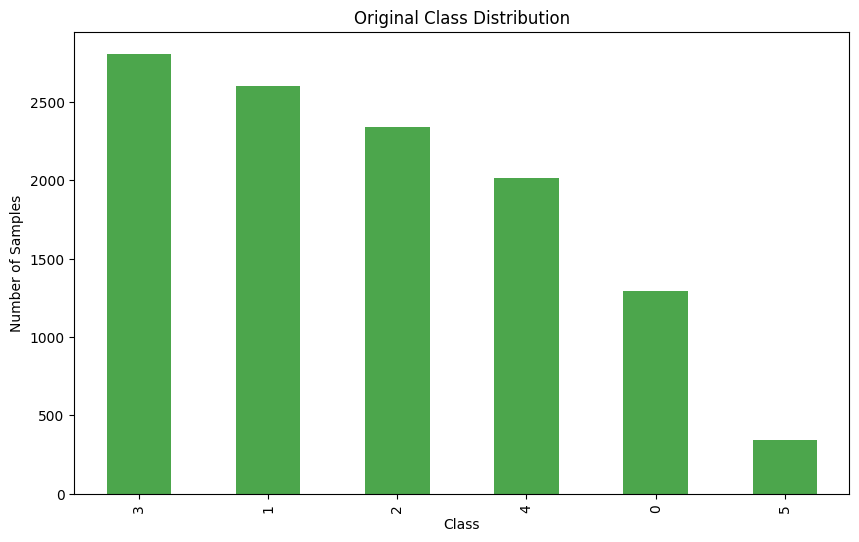

In [ ]:
# Plot class distribution helper
def plot_class_distribution(labels, title, color):
    plt.figure(figsize=(10,6))
    pd.Series(labels).value_counts().plot(kind='bar', color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

plot_class_distribution(data_df['label'], 'Original Class Distribution', 'green')

In [ ]:
# Load and resize images (normalized to [0,1])
def load_and_resize_images(image_paths, target_size=(150,150)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

X_images = load_and_resize_images(data_df['image_path'])
y_labels = data_df['label'].values

In [ ]:
# Split into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2,
                                                     random_state=42, stratify=y_labels)

Original training distribution: {0: 1037, 1: 2081, 2: 1872, 3: 2245, 4: 1613, 5: 273}
Imbalance ratio: 8.22
Data is imbalanced. Attempting to apply ADASYN...
ADASYN did not generate new samples: No samples will be generated with the provided ratio settings.
Using original training data instead.


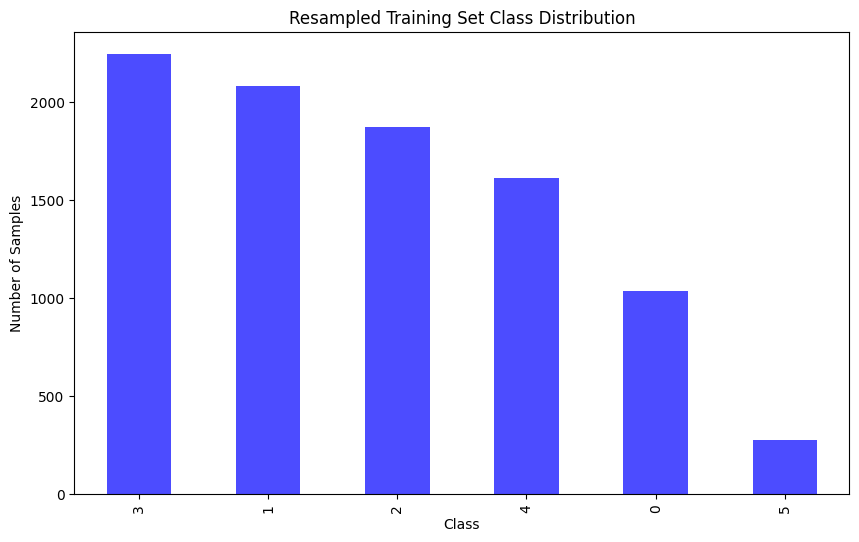

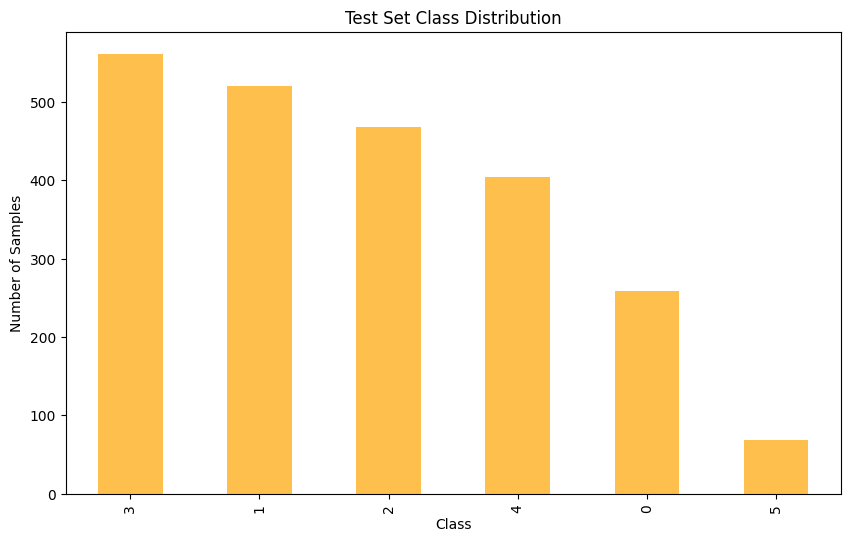

In [ ]:
# Flatten training images for oversampling
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Check class distribution in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("Original training distribution:", dict(zip(unique, counts)))

imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.1:
    print("Data is imbalanced. Attempting to apply ADASYN...")
    try:
        adasyn = ADASYN(random_state=42)
        X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_flat, y_train)
        # Reshape back to image dimensions
        X_train_resampled = X_train_resampled.reshape(-1, 150, 150, 3)
    except ValueError as e:
        print("ADASYN did not generate new samples:", e)
        print("Using original training data instead.")
        X_train_resampled, y_train_resampled = X_train, y_train
else:
    print("Data is balanced. Skipping ADASYN...")
    X_train_resampled, y_train_resampled = X_train, y_train

# Plot the class distributions for verification
plot_class_distribution(y_train_resampled, 'Resampled Training Set Class Distribution', 'blue')
plot_class_distribution(y_test, 'Test Set Class Distribution', 'orange')


In [ ]:
# 2. PCA & Angle Encoding for Quantum Data

# Reduce dimensionality of flattened images using PCA
n_components = 10  # Set number of PCA components (and qubits)
pca = PCA(n_components=n_components, random_state=42)
X_train_resampled_flat = X_train_resampled.reshape(X_train_resampled.shape[0], -1)
X_train_pca = pca.fit_transform(X_train_resampled_flat)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_pca = pca.transform(X_test_flat)

In [ ]:
# Function to scale PCA features to the range [0, pi] for angle encoding
def scale_to_angle(data, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.min(data, axis=0)
    if max_val is None:
        max_val = np.max(data, axis=0)
    return np.pi * (data - min_val) / (max_val - min_val + 1e-8)

X_train_angles = scale_to_angle(X_train_pca)
X_test_angles = scale_to_angle(X_test_pca)

In [ ]:
# Convert image and quantum (angle-encoded) data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
X_train_angles_tensor = torch.tensor(X_train_angles, dtype=torch.float32)
X_test_angles_tensor = torch.tensor(X_test_angles, dtype=torch.float32)

n_classes = len(data_df['label'].unique())
y_train_tensor = F.one_hot(torch.tensor(y_train_resampled, dtype=torch.long), num_classes=n_classes).float()
y_test_tensor = F.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=n_classes).float()

In [ ]:
# Create DataLoaders that supply both image data and PCA angle features
train_dataset = TensorDataset(X_train_tensor, X_train_angles_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_angles_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Counts: {'111': 100}


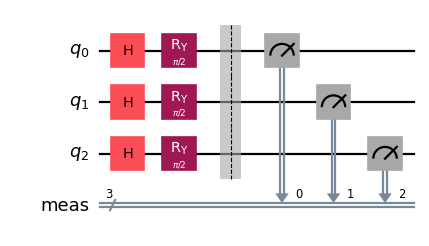

In [ ]:
# 3. Define Quantum & Hybrid Layers

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator

# Quantum circuit using angle encoding (one angle per qubit)
class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits  # Must equal number of PCA components
        self.backend = backend
        self.shots = shots

    def run(self, angles):
        angles = np.array(angles).flatten()
        circuit = QuantumCircuit(self.n_qubits)
        for qubit in range(self.n_qubits):
            circuit.h(qubit)
            circuit.ry(angles[qubit], qubit)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()
        counts_array = np.array(list(counts.values()))
        states_array = np.array([int(state, 2) for state in counts.keys()])
        probabilities = counts_array / self.shots
        expectation = np.sum(states_array * probabilities)
        return np.array([expectation])

    def draw_circuit(self, theta):
        # Create a new circuit with the parameter value
        circuit = QuantumCircuit(self.n_qubits)
        for qubit in range(self.n_qubits):
            circuit.h(qubit)
            circuit.ry(theta, qubit)
        circuit.measure_all()

        # Transpile the circuit
        transpiled_circuit = transpile(circuit, AerSimulator())

        # Execute the job using the AerSimulator
        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)

        # Print the counts
        print("Counts:", counts)

        # Draw the circuit and show the plot
        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

# Initialize the quantum circuit and plot it for 3 qubits
quantum_circuit = MyQuantumCircuit(3, AerSimulator(), 100)
quantum_circuit.draw_circuit(np.pi / 2)

In [ ]:
# Hybrid function with parameter shift for vector inputs
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectations = []
        for sample in input:
            angles = sample.detach().cpu().numpy()
            exp_val = ctx.quantum_circuit.run(angles)
            expectations.append(exp_val)
        result = torch.tensor(expectations, dtype=torch.float32, device=input.device)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, output = ctx.saved_tensors
        gradients = []
        for sample in input:
            sample_grad = []
            for i in range(len(sample)):
                shifted_right = sample.clone()
                shifted_left = sample.clone()
                shifted_right[i] += ctx.shift
                shifted_left[i] -= ctx.shift
                exp_right = ctx.quantum_circuit.run(shifted_right.detach().cpu().numpy())
                exp_left = ctx.quantum_circuit.run(shifted_left.detach().cpu().numpy())
                grad_i = (exp_right - exp_left) / (2 * ctx.shift)
                sample_grad.append(grad_i)
            gradients.append(sample_grad)
        gradients = torch.tensor(gradients, dtype=torch.float32, device=input.device)
        return gradients * grad_output, None, None

In [ ]:
# Hybrid quantum layer
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift, n_qubits):
        super(Hybrid, self).__init__()
        self.quantum_circuit = MyQuantumCircuit(n_qubits, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
# 4. Define the Hybrid CNN–Quantum Model

# The model processes image data via CNN layers (classical branch)
# and uses PCA angle features in the quantum branch.
class Net(nn.Module):
    def __init__(self, pca_dim):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d()
        # Hybrid quantum layer: outputs a scalar per sample
        self.hybrid = Hybrid(AerSimulator(), 100, np.pi/2, n_qubits=pca_dim)
        self._flattened_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self._flattened_size, 64)
        # Combine classical features (64) with quantum output (1)
        self.fc2 = nn.Linear(64 + 1, n_classes)

    def _get_flattened_size(self):
        dummy = torch.zeros(1, 3, 150, 150)
        x = self.pool(F.relu(self.conv1(dummy)))
        x = self.pool(F.relu(self.conv2(x)))
        return int(np.prod(x.size()))

    def forward(self, x, quantum_input):
        # Classical CNN branch
        x_cls = self.pool(F.relu(self.conv1(x)))
        x_cls = self.pool(F.relu(self.conv2(x_cls)))
        x_cls = self.dropout(x_cls)
        x_cls = x_cls.view(x_cls.size(0), -1)
        x_cls = F.relu(self.fc1(x_cls))
        # Quantum branch processes PCA angle-encoded features
        x_quantum = self.hybrid(quantum_input)
        # Concatenate branches and classify
        x_combined = torch.cat((x_cls, x_quantum), dim=1)
        output = self.fc2(x_combined)
        return output

model = Net(pca_dim=n_components)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

<ipython-input-16-6a2c7c941fe0>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  result = torch.tensor(expectations, dtype=torch.float32, device=input.device)


Epoch 1/20, Loss: 10.0487
Epoch 2/20, Loss: 1.3620
Epoch 3/20, Loss: 1.1791
Epoch 4/20, Loss: 1.1145
Epoch 5/20, Loss: 1.0361
Epoch 6/20, Loss: 0.9685
Epoch 7/20, Loss: 0.9094
Epoch 8/20, Loss: 0.8549
Epoch 9/20, Loss: 0.8045
Epoch 10/20, Loss: 0.7563
Epoch 11/20, Loss: 0.7032
Epoch 12/20, Loss: 0.6544
Epoch 13/20, Loss: 0.5929
Epoch 14/20, Loss: 0.5930
Epoch 15/20, Loss: 0.5775
Epoch 16/20, Loss: 0.4761
Epoch 17/20, Loss: 0.4301
Epoch 18/20, Loss: 0.4275
Epoch 19/20, Loss: 0.3981
Epoch 20/20, Loss: 0.3438


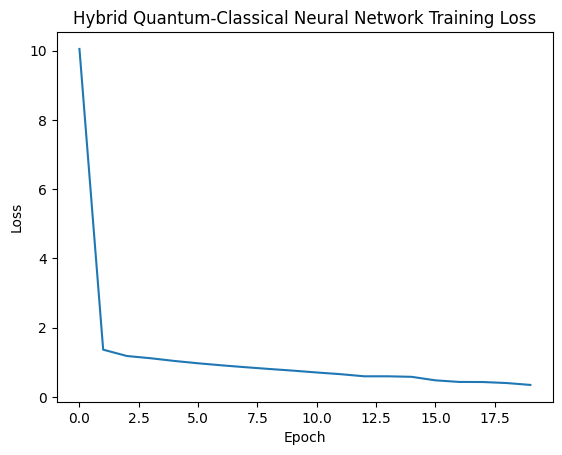

In [ ]:
# 5. Training Loop with Early Stopping

patience = 10
best_loss = float('inf')
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for images, quantum_features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(images, quantum_features)
        loss = loss_func(outputs, targets.argmax(dim=1))
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    avg_loss = sum(total_loss) / len(total_loss)
    loss_list.append(avg_loss)
    scheduler.step(avg_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_wts)
plt.plot(loss_list)
plt.title('Hybrid Quantum-Classical Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Average Test Loss: 1.4140
Test Accuracy: 58.92%
Macro-F1 Score: 0.60
Precision: 0.66
Recall: 0.61
AUROC Score: 0.91
Confusion Matrix:
 [[133   0 116   0   5   5]
 [  5 124  15  21 351   4]
 [ 52   6 381   0  21   8]
 [  0  33   1 317 209   1]
 [  2  37  11  11 342   1]
 [  4   5   7   0   6  47]]


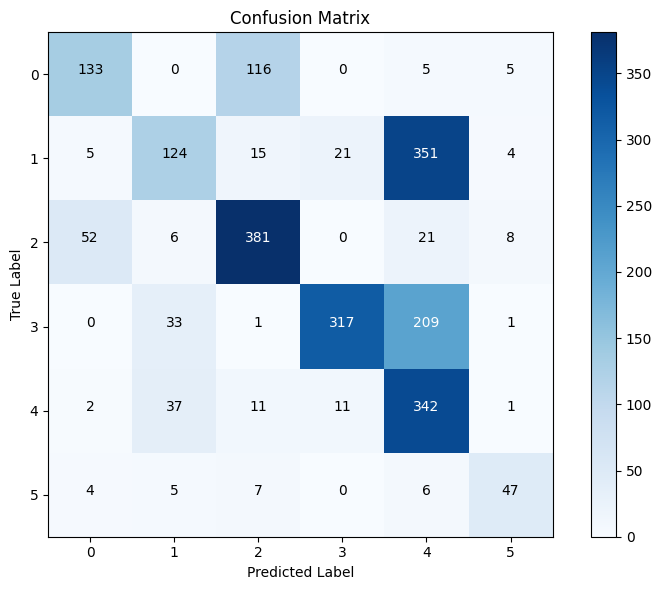

In [ ]:
# 6. Model Evaluation

model.eval()
all_preds = []
all_labels = []
total_loss_eval = []
all_probs = []

with torch.no_grad():
    for images, quantum_features, targets in test_loader:
        outputs = model(images, quantum_features)
        loss = loss_func(outputs, targets.argmax(dim=1))
        total_loss_eval.append(loss.item())
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = targets.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

avg_loss_eval = sum(total_loss_eval) / len(total_loss_eval)
accuracy = (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels) * 100
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
auroc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovo', average='macro')

print(f"Average Test Loss: {avg_loss_eval:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Macro-F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUROC Score: {auroc:.2f}")

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(n_classes)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
thresh = cm.max()/2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [ ]:
# 7. GradCAM for Explainability

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, class_idx, quantum_feature):
        self.model.eval()
        output = self.model(input_image.unsqueeze(0), quantum_feature.unsqueeze(0))
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.clone()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        cam = torch.mean(activations, dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam.cpu().numpy()

In [ ]:
# Generate GradCAM visualization for a sample test image
gradcam = GradCAM(model, model.conv2)
sample_img, sample_quantum, sample_target = next(iter(test_loader))
sample_img = sample_img[0]
sample_quantum = sample_quantum[0]
with torch.no_grad():
    output = model(sample_img.unsqueeze(0), sample_quantum.unsqueeze(0))
pred_class = output.argmax(dim=1).item()
cam_heatmap = gradcam.generate_cam(sample_img, pred_class, sample_quantum)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


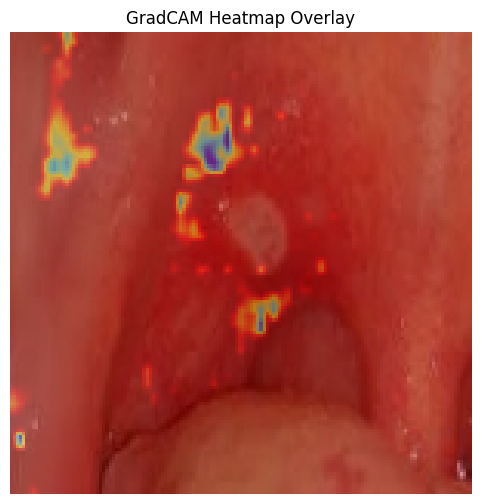

In [ ]:
# Overlay the heatmap on the original image
img_np = sample_img.permute(1, 2, 0).cpu().numpy()
heatmap = cv2.resize(cam_heatmap, (img_np.shape[1], img_np.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.uint8(255*img_np), 0.6, heatmap, 0.4, 0)
plt.figure(figsize=(8,6))
plt.imshow(overlay)
plt.title("GradCAM Heatmap Overlay")
plt.axis("off")
plt.show()

In [ ]:
# 8. Decision Boundary Analysis

# Function to extract CNN branch features (from conv layers) for visualization
def extract_features(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, quantum_features, targets in loader:
            x = model.pool(F.relu(model.conv1(images)))
            x = model.pool(F.relu(model.conv2(x)))
            features.append(x.view(x.size(0), -1).cpu().numpy())
            labels.append(targets.argmax(dim=1).cpu().numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

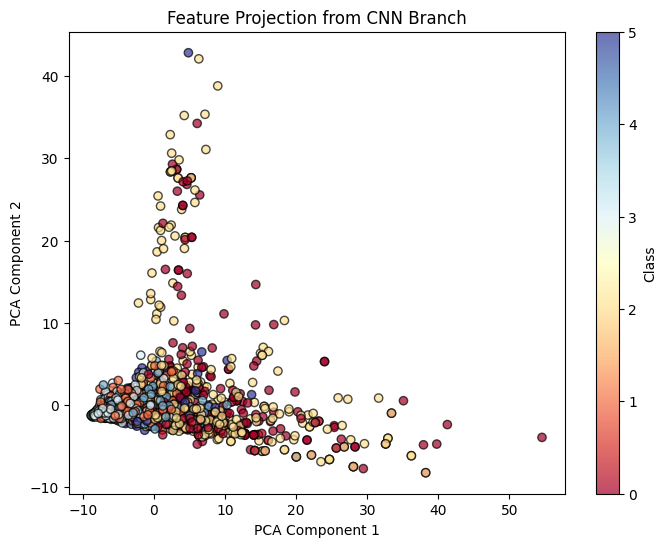

In [ ]:
# Extract features from test data and project to 2D using PCA
features, labels = extract_features(model, test_loader)
pca_features = PCA(n_components=2, random_state=42).fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels,
            cmap=plt.cm.RdYlBu, edgecolor='k', alpha=0.7)
plt.title("Feature Projection from CNN Branch")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Class")
plt.show()
